## MPAA rating prediction

In [65]:
import pandas as pd
import numpy as np
import warnings
import re
import pickle
import seaborn as sns

%matplotlib inline
warnings.filterwarnings('ignore')

Import dataset :: imdb dataset

In [66]:
from dataset import get_dataframe
dataset = get_dataframe('./dataset_cleaned_emotions')

dataset.head()
dataset.shape

(15455, 41)

In [67]:
## Clean data
dataset.dropna()
dataset.columns = dataset.columns.str.replace(" ", "")
#dataset = dataset[dataset.synopsis != ''] # cannot do this
dataset = dataset[dataset.clean_description != '']
#dataset = dataset[dataset.clean_storyline != '']
dataset.shape

(15455, 41)

## Prepare data

In [68]:
dataset_df = pd.DataFrame()
for index, row in dataset.iterrows():
    try:
        new_row = {
            "Title"    : row["name"],
            "Description" : row["clean_description"],
            "negative" : row["negative"],
            "sadness"  : row["sadness"],
            "trust"    : row["trust"],
            "anger"    : row["anger"],
            "positive" : row["positive"],
            "fear"     : row["fear"],
            "disgust"  : row["disgust"],
            "surprise" : row["surprise"],
            "anticipation"  : row["anticipation"],
            "joy"  : row["joy"],
            "Rating" : row["rating"]
        }
        dataset_df = dataset_df.append( new_row, ignore_index=True )
    except Exception as ex:
        continue

In [69]:
dataset_df = dataset_df[['Title', 'Rating', 'Description']]
dataset_df.columns = dataset_df.columns.str.strip()
dataset_df.head(4)

,Title,Rating,Description
0,The Cellar,PG-13,young boy finds ancient comanche monster spiri...
1,The Cemetery Club,PG-13,lifelong friends meet weekly celebrate past pr...
2,The Challenger,PG-13,struggling bronx mechanic jaden miller uses bo...
3,The Chaperone,PG-13,ex con run criminal past hides ratted chaperon...


In [70]:
# finding unique mpaa rating in the dataset
dataset_df['Rating'].unique()

array(['PG-13', 'PG', 'R', 'G', 'NC-17'], dtype=object)

In [71]:
# clean mpaa ratings
mpaa_fix = {
    'PG-13 ' : 'PG-13',
    'R ' : 'R',
    'PG ': 'PG',
    'G ' : 'G',
    'NR ': 'NR',
    'NC17 ': 'NC17'
}
for i, rating in dataset_df['Rating'].iteritems():
    if rating in mpaa_fix.keys():
        fix_val = mpaa_fix.get(rating)
        dataset_df.iloc[i]['Rating'] = fix_val
dataset_df['Rating'].unique()

array(['PG-13', 'PG', 'R', 'G', 'NC-17'], dtype=object)

In [72]:
# Clean the movie description
def clean_description( text_str ):
    text = re.sub('[^a-zA-Z]',  ' ', text_str)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

for i, description in dataset_df['Description'].iteritems():
    dataset_df.iloc[i]['Description'] = clean_description( str(description) )

## Data Distribution

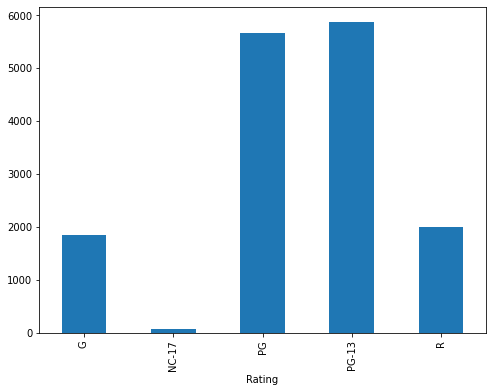

In [73]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
dataset_df.groupby('Rating')['Description'].count().plot.bar(ylim=0)
plt.show()

In [74]:
## drop NC-17
dataset_df = dataset_df[dataset_df.Rating != 'NC-17'] 

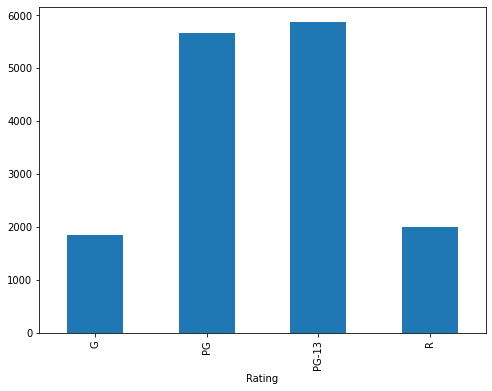

In [75]:
fig = plt.figure(figsize=(8,6))
dataset_df.groupby('Rating')['Description'].count().plot.bar(ylim=0)
plt.show()

In [76]:
pickle.dump(dataset_df, open('./data/dataset_df_imdb_cleaned.pkl', 'wb'))

## Training model

In [77]:
training_df = pickle.load( open('./data/dataset_df_imdb_cleaned.pkl', 'rb') )

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, LSTM, Embedding, GlobalMaxPooling1D

In [79]:
_y = training_df['Rating']
encoder = LabelEncoder()
Y = encoder.fit_transform(_y)
Y

array([2, 2, 2, ..., 3, 3, 3])

In [80]:
X = training_df['Description']
X

0        young boy finds ancient comanche monster spiri...
1        lifelong friends meet weekly celebrate past pr...
2        struggling bronx mechanic jaden miller uses bo...
3        ex con run criminal past hides ratted chaperon...
4        crimean war poor planning leads british light ...
                               ...                        
15450    driving wedding los angeles mojave desert paul...
15451    watching best friend get murdered group teens ...
15452    killing machine goes killing spree best friend...
15453    convicted wife murderer returns year later see...
15454                                             add plot
Name: Description, Length: 15381, dtype: object

## Train, test split

In [81]:
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.3, random_state=40 )

In [82]:
Y_train = to_categorical(Y_train)
Y_test  = to_categorical(Y_test)

In [83]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

In [84]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test  = tokenizer.texts_to_sequences(X_test)

In [85]:
vocabulary_size = len(tokenizer.word_index) + 1
maxlen = 400 # Only concider first 400 words of each description

X_train = pad_sequences( X_train, maxlen=maxlen )
X_test  = pad_sequences( X_test, maxlen=maxlen )

## Use GloVe : Global Vectors for Word Representation
https://nlp.stanford.edu/projects/glove/

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. 

In [86]:
glove_file = open('./glove.6B/glove.6B.100d.txt', encoding='utf8')

In [87]:
embedd_dictionary = dict()
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dims = np.asarray(records[1:], dtype='float32')
    embedd_dictionary[word] = vector_dims

glove_file.close()

In [88]:
embedd_matrix = np.zeros((vocabulary_size, 100))
for word, index in tokenizer.word_index.items():
    embedd_vector = embedd_dictionary.get(word)
    if embedd_vector is not None:
        embedd_matrix[index] = embedd_vector

## Build the NN Model

In [91]:
model = Sequential()
model.add(Embedding(input_dim=vocabulary_size, output_dim=100, weights=[embedd_matrix], trainable=False))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         2216400   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 516       
Total params: 2,334,164
Trainable params: 117,764
Non-trainable params: 2,216,400
_________________________________________________________________


In [92]:
hist = model.fit(X_train, Y_train, batch_size=128, epochs=40, validation_split=0.20, verbose=1)

Epoch 1/40
59/59 [==============================] - 39s 638ms/step - loss: 1.2765 - accuracy: 0.3648 - val_loss: 1.1865 - val_accuracy: 0.4477
Epoch 2/40
59/59 [==============================] - 42s 715ms/step - loss: 1.1703 - accuracy: 0.4424 - val_loss: 1.1713 - val_accuracy: 0.4477
Epoch 3/40
59/59 [==============================] - 42s 719ms/step - loss: 1.1504 - accuracy: 0.4575 - val_loss: 1.1690 - val_accuracy: 0.4406
Epoch 4/40
59/59 [==============================] - 42s 714ms/step - loss: 1.1465 - accuracy: 0.4561 - val_loss: 1.1659 - val_accuracy: 0.4517
Epoch 5/40
59/59 [==============================] - 42s 714ms/step - loss: 1.1339 - accuracy: 0.4784 - val_loss: 1.1634 - val_accuracy: 0.4539
Epoch 6/40
59/59 [==============================] - 44s 740ms/step - loss: 1.1285 - accuracy: 0.4738 - val_loss: 1.1618 - val_accuracy: 0.4486
Epoch 7/40
59/59 [==============================] - 41s 695ms/step - loss: 1.1054 - accuracy: 0.5078 - val_loss: 1.1942 - val_accuracy: 0.4452

In [93]:
loss, acc = model.evaluate(X_test, Y_test, verbose=1)
print('loss: ', loss)
print('accuracy: ', acc)

145/145 [==============================] - 16s 110ms/step - loss: 2.0970 - accuracy: 0.4095
loss:  2.0969700813293457
accuracy:  0.40953412652015686


## Save model and tokenizer

In [94]:
# save model
model.save('./data/mpaa_classifier_imdb.h5')

# save word tokenizer
pickle.dump(tokenizer, open('./data/tokenizer_imdb.pkl', 'wb'))

## Metrics

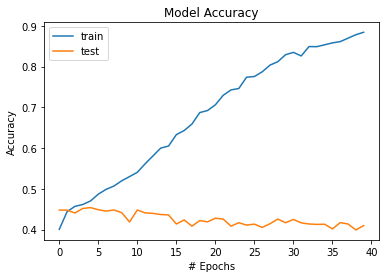

In [95]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('# Epochs')
plt.legend(['train', 'test'])
plt.show()

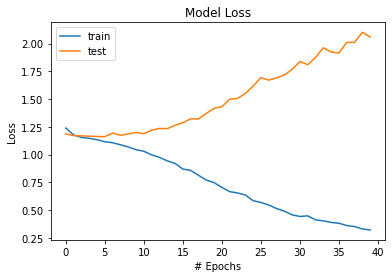

In [96]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('# Epochs')
plt.legend(['train', 'test'])
plt.show()